In [64]:
import torch                     # for all things PyTorch
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function

In [65]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [66]:
net = LeNet()
print(net)                         # what does the object tell us about itself?

input = torch.rand(1, 1, 32, 32)   # stand-in for a 32x32 black & white image
print('\nImage batch shape:')
print(input.shape)

output = net(input)                # we don't call forward() directly
print('\nRaw output:')
print(output)
print(output.shape)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image batch shape:
torch.Size([1, 1, 32, 32])

Raw output:
tensor([[-0.0164,  0.1396,  0.0208,  0.0906, -0.0294,  0.0429,  0.0394,  0.0114,
         -0.0208, -0.0270]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


In [67]:
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)


Download the MNIST training and test sets and transform images to PyTorch tensors (numerical arrays). Each image is 28×28 grayscale, and each label is one of 10 digits. After downloading, the code below creates data loaders for convenient batching:

In [68]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

This prepares to feed the data in batches of 64 images at a time (common for training)
docs.pytorch.org
docs.pytorch.org
.

In [69]:
import torch
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.4),  # Dropout added here
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.fc_stack(x)
        return x

# Instantiate the model
model = ConvNet()

This model definition corresponds to the diagram above: flatten input to 784, then two linear layers with ReLU, then a final linear layer to get 10 outputs.

Using PyTorch’s torch.nn module, define a simple feed-forward neural network. For example, you can create a class NeuralNetwork(nn.Module) with an __init__ that sets up layers, and a forward method that defines how data flows. A basic architecture for MNIST could be:

Input layer: 784 inputs (since 28*28 pixels are flattened into a vector).

Hidden layer 1: 512 neurons + ReLU activation.

Hidden layer 2: 512 neurons + ReLU activation.

Output layer: 10 neurons (one for each digit class).


In [70]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

Now, I set up a loss function and optimizer for training. For multi-class classification, I use cross-entropy loss (nn.CrossEntropyLoss), and a simple optimizer like Stochastic Gradient Descent (torch.optim.SGD). Here we use a learning rate of 0.01 (1e-2) – this might be adjusted if needed. Now write the training loop. Loop for a certain number of epochs (passes through the dataset, say 5 epochs to start). In each epoch, iterate over train_loader batches:

In [75]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    total_loss = 0

    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} complete | Avg Loss: {avg_loss:.4f}")


Epoch 1, Batch 0, Loss: 2.3045
Epoch 1, Batch 100, Loss: 0.2733
Epoch 1, Batch 200, Loss: 0.2026
Epoch 1, Batch 300, Loss: 0.1019
Epoch 1, Batch 400, Loss: 0.2037
Epoch 1, Batch 500, Loss: 0.2379
Epoch 1, Batch 600, Loss: 0.0838
Epoch 1, Batch 700, Loss: 0.0325
Epoch 1, Batch 800, Loss: 0.0676
Epoch 1, Batch 900, Loss: 0.0180
Epoch 1 complete | Avg Loss: 0.1936
Epoch 2, Batch 0, Loss: 0.0672
Epoch 2, Batch 100, Loss: 0.1193
Epoch 2, Batch 200, Loss: 0.0562
Epoch 2, Batch 300, Loss: 0.0595
Epoch 2, Batch 400, Loss: 0.0080
Epoch 2, Batch 500, Loss: 0.0963
Epoch 2, Batch 600, Loss: 0.0725
Epoch 2, Batch 700, Loss: 0.0234
Epoch 2, Batch 800, Loss: 0.0228
Epoch 2, Batch 900, Loss: 0.0219
Epoch 2 complete | Avg Loss: 0.0683
Epoch 3, Batch 0, Loss: 0.0080
Epoch 3, Batch 100, Loss: 0.0490
Epoch 3, Batch 200, Loss: 0.0401
Epoch 3, Batch 300, Loss: 0.0671
Epoch 3, Batch 400, Loss: 0.0054
Epoch 3, Batch 500, Loss: 0.0472
Epoch 3, Batch 600, Loss: 0.0052
Epoch 3, Batch 700, Loss: 0.0541
Epoch 3, B

This loop does: for each batch, get predictions, compute the loss against true labels, then do backpropagation (loss.backward()) and update weights (optimizer.step()), clearing gradients in between
docs.pytorch.org
docs.pytorch.org
. The model’s parameters get adjusted in each step to reduce the loss. By the end of each epoch, the network has seen all training examples once. Print a message or loss value occasionally to track progress.

In [76]:
model.eval()  # set to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # no grad needed for eval
    for X, y in test_loader:
        X, y = X.to("cuda"), y.to("cuda")
        pred = model(X)
        # pick class with highest predicted score for each sample
        predicted_labels = pred.argmax(dim=1)
        correct += (predicted_labels == y).sum().item()
        total += y.size(0)
print(f"Test Accuracy: {100 * correct/total:.2f}%")

Test Accuracy: 99.23%


Below is a visualization of a random image from the MINST dataset and then the model I created being run on the image. The predicted output from the image is listed below the code.

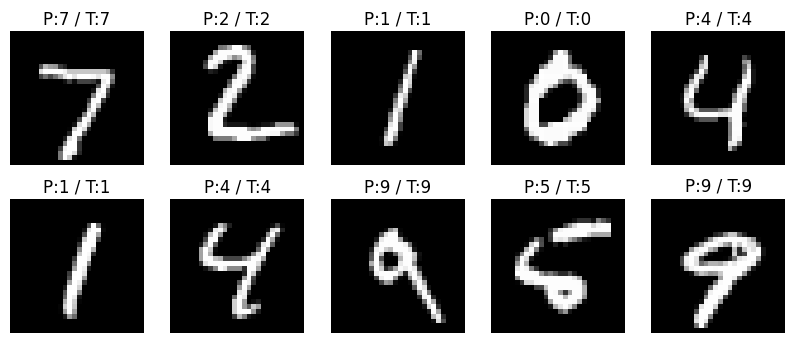

In [78]:
model.eval()
images, labels = next(iter(test_loader))
images = images.to(device)
outputs = model(images)
preds = outputs.argmax(dim=1)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title(f"P:{preds[i].item()} / T:{labels[i].item()}")
    plt.axis('off')
plt.show()

In [77]:
# Save
torch.save(model.state_dict(), "mnist_cnn.pt")

# Load later
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

ConvNet(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

To improve model performance on the MNIST digit classification task, several key techniques were implemented. The input data was normalized using the dataset’s mean and standard deviation to stabilize and accelerate training. A convolutional neural network (CNN) architecture was used in place of a basic feedforward network, allowing the model to better capture spatial patterns in image data. Dropout regularization was added to the fully connected layers to reduce overfitting. The optimizer was upgraded from stochastic gradient descent (SGD) to Adam, which adapts learning rates and generally leads to faster convergence. The model was trained over 10 epochs with loss tracking per batch and epoch to monitor performance. Together, these improvements raised the model’s accuracy to 99.23%, demonstrating high generalization and robustness.